# Dark current: the ideal case

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

from image_sim import dark_current, read_noise


## A dark frame measures dark current

Recall that *dark current* refers to counts (electrons) generated in a pixel because an electron in the pixel happens to have enough energy to "break free" and register as a count. The distribution of electron thermal energies in  pixel follows a [Maxwell-Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution) in which most electrons have energy around $kT$, where $T$ is the temperature of the sensor and $k$ is the Boltzmann constant. There is a distribution of energies, though, and occasionally an electron will be high enough energy to jump to the conducting band in the chip, registering the same as an electron excited by a photon. Since the Maxwell-Boltzmann distribution depends on temperature the rate at which dark current appears in a pixel is also expected to depend on temperature. 

A *dark frame* (also called a *dark image*) is an image taken with your camera with the shutter closed. It is the sum of the bias level of your camera, the readout noise, and the dark current.

You measure the dark current in your camera by taking dark frames.

### Convenience functions

A couple of functions that will be reused a few times in this notebook are defined below.

**A function to generate dark frames**

This function generates a set of dark frames. It will be used several times below.

In [2]:
def generate_dark_frames(n_frames, 
                         dark_rate=0, 
                         noise=0,
                         gain=1,
                         exposure=10,
                         image_size=500):
    
    base_image = np.zeros([image_size, image_size])
    darks = np.zeros([n_frames, image_size, image_size])
    
    for n in range(n_images):
        darks[n] = dark_current(base_image, dark_rate, exposure, gain=gain, hot_pixels=False)
        if noise > 0:
            darks[n] = darks[n] + read_noise(base_image, noise, gain=gain)

    return darks

**A function to plot the distribution of dark counts**

The function below plots the 

In [3]:
def plot_dark_with_distributions(image, rn, dark_rate, 
                                 n_images=1,
                                 exposure=1,
                                 gain=1,
                                 show_poisson=True, 
                                 show_gaussian=True):
    """
    Plot the distribution of dark pixel values, optionally overplotting the expected Poisson and
    normal distributions corresponding to dark current only or read noise only.
    
    Parameters
    ----------
    
    image : numpy array
        Dark frame to histogram.
    
    rn : float
        The read noise, in electrons.
        
    dark_rate : float
        The dark current in electrons/sec/pixel.
    
    n_images : float, optional
        If the image is formed from the average of some number of dark frames then 
        the resulting Poisson distribution depends on the number of images, as does the 
        expected standard deviation of the Gaussian.
        
    exposure : float
        Exosure time, in seconds.
        
    gain : float, optional
        Gain of the camera, in electron/ADU.
        
    show_poisson : bool, optional
        If ``True``, overplot a Poisson distribution with mean equal to the expected dark
        counts for the number of images.
    
    show_gaussian : bool, optional
        If ``True``, overplot a normal distribution with mean equal to the expected dark
        counts and standard deviation equal to the read noise, scaled as appropiate for 
        the number of images.
    """
    
    h = plt.hist(image.flatten(), bins=20, align='mid', 
                 density=True, label="Dark frame");

    bins = h[1]
    
    expected_mean_dark = dark_rate * exposure / gain
    
    pois = stats.poisson(expected_mean_dark * n_images)

    pois_x = np.arange(0, 300, 1)

    new_area = np.sum(1/n_images * pois.pmf(pois_x))

    if show_poisson:
        plt.plot(pois_x / n_images, pois.pmf(pois_x) / new_area, 
                 label="Poisson dsitribution, mean of {:5.2f} counts".format(expected_mean_dark)) 

    if show_gaussian:
        # The expected width of the Gaussian depends on the number of images.
        expected_scale = rn / gain * np.sqrt(n_images)
        
        # Mean value is same as for the Poisson distribution 
        expected_mean = expected_mean_dark * n_images
        gauss = stats.norm(loc=expected_mean, scale=expected_scale)
        
        gauss_x = np.linspace(expected_mean - 5 * expected_scale,
                              expected_mean + 5 * expected_scale,
                              num=100)
        plt.plot(gauss_x / n_images, gauss.pdf(gauss_x) * n_images, label='Gaussian, standard dev is read noise in counts') 
        
    plt.xlabel("Dark counts in {} sec exposure".format(exposure))
    plt.ylabel("Fraction of pixels (area normalized to 1)")
    plt.grid()
    plt.legend()

## Dark current theory

The expected signal in a dark frame exposure of time $t$ is proportional to $t$. If we call the dark electrons in an exposure $d_e(t)$ and the dark current $d_c(T)$, where $T$ is the temperature, then 

$$
d_e(t) = d_c(T) t.
$$

For liquid-cooled cameras, particularly ones cooled by liquid nitrogen, the operating temperature doesn't change. For thermo-electrically cooled cameras one is able to set the desired operating temperature. As a result, you should be able to ignore the temperature dependence of the dark current.

The thermo-electric coolers can usually cool by some fixed amount below the ambient temperature. Though in principle one could choose to always cool by the same fixed amount, like $50^\circ$C below the ambient temperature, there is an advantage to always running your camera at the same temperature: dark frames taken on one date are potentially useful on another date. If the operating temperature varies then you need to make sure to take dark frames every time you observe unless you carefully characterize the temperature dependence of your dark current. 

It will turn out that for practical reasons -- not all pixels in your camera have the same dark current -- it is usually best to take dark frames every time you observe anyway.

## Illustration with dark current only

For the purposes of illustrating some of the properties of dark current and dark frames we'll generate some simulated images in which the counts are due to dark current alone. We'll use these values:

+ Dark current is $d_c(T) = 0.1 e^-$/pixel/sec
+ Gain is $g = 1.5 e^-$/ADU
+ Read noise is 0 $e^-$

In [4]:
dark_rate = 0.1
gain = 1.5
read_noise_electrons = 0

### Dark current is a random process

The dark counts in a dark frame are counts and so they follow a Poisson distribution. The plot below shows the dark current in a number of randomly chosen pixels in 20 different simulated images each with exposure time 100 sec. Note that the counts vary from image to image but that the average is very close to the expected value.

The expected value of the dark counts for this image are $d_e(t)/g = 6.67~$counts.

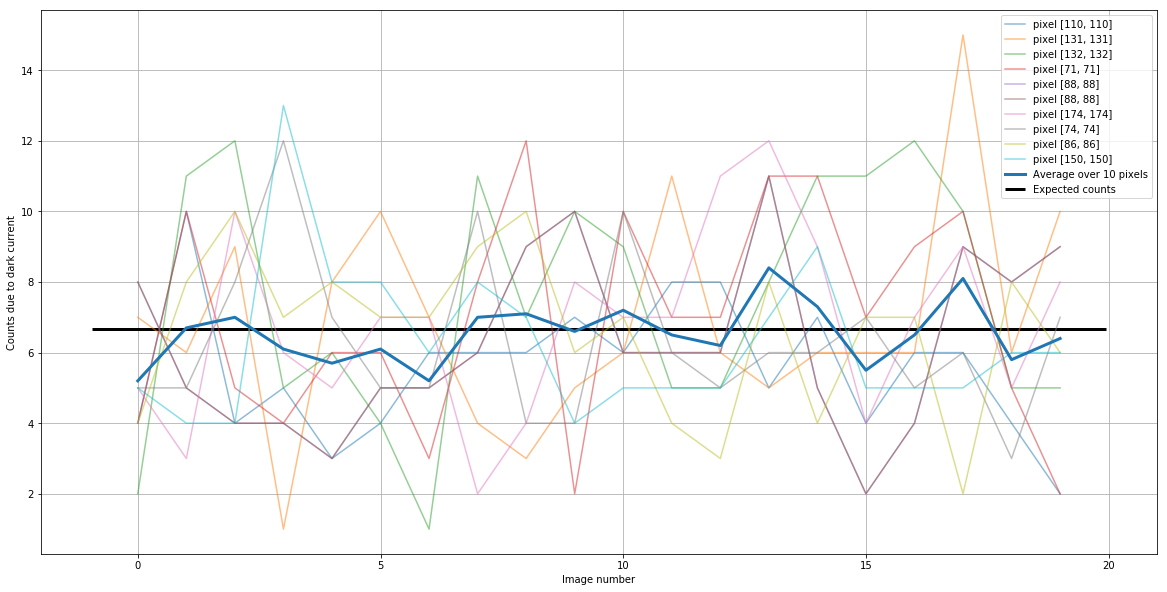

In [5]:
exposure = 100

n_images = 20
n_pixels = 10
image_size = 500



plt.figure(figsize=(20, 10))

darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=read_noise_electrons,
                             gain=gain, exposure=100, image_size=image_size)


# Pick several random pixels to plot
pixels = np.random.randint(50, high=190, size=n_pixels)
pixel_values = np.zeros(n_images)
pixel_averages = np.zeros(n_images)

for pixel in pixels:
    for n in range(n_images):
        pixel_values[n] = darks[n, pixel, pixel]
    plt.plot(pixel_values, label='pixel [{0}, {0}]'.format(pixel), alpha=0.5)
    pixel_averages += pixel_values


plt.plot(pixel_averages / n_pixels, 
         linewidth=3,
         label='Average over {} pixels'.format(n_pixels))
# plt.xlim(0, n_images - 1)
plt.hlines(dark_rate * exposure / gain, *plt.xlim(), 
           linewidth=3, 
           label="Expected counts")
plt.xlabel('Image number')
plt.ylabel('Counts due to dark current')

plt.legend()
plt.grid()

### Dark counts follows a Poisson distribution

The distribution below shows a normalized histogram of number of pixels as a function of dark counts in each pixel for one of the simulated dark frames. Overlaid on the histogram is a Poisson distribution with a mean of $d_e(t_{exp}) = d_C(T) * t_{exp} / g$, where $t_{exp}$ is the exposure time.

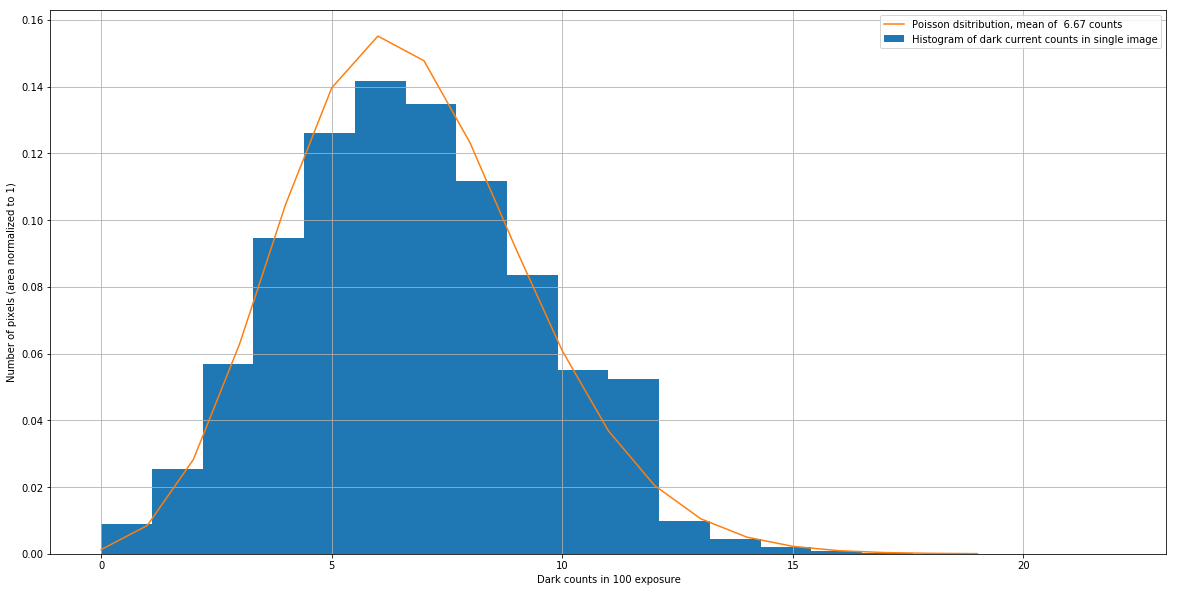

In [6]:
plt.figure(figsize=(20, 10))


h = plt.hist(darks[-1].flatten(), bins=20, align='mid', density=True, 
             label="Histogram of dark current counts in single image");
bins = h[1]
pois = stats.poisson(dark_rate * exposure / gain)
pois_x = np.arange(0, 20, 1)

plt.plot(pois_x, pois.pmf(pois_x), 
         label="Poisson dsitribution, mean of {:5.2f} counts".format(dark_rate * exposure / gain))  

plt.xlabel("Dark counts in {} exposure".format(exposure))
plt.ylabel("Number of pixels (area normalized to 1)")
plt.legend()
plt.grid()

## Illustration with dark current and read noise

Now let's run through the same couple of plots with a non-zero read noise. For the sake of illustration, we'll look at two cases:

1. Moderate read noise of 10 $e^-$ per read, typical of a low-end research-grade CCD
2. Low read noise of 1 $e^-$ per read

In both cases we'll continue with the parameters above to generate our frames:

+ Dark current is $d_c(T) = 0.1 e^-$/pixel/sec
+ Gain is $g = 1.5 e^-$/ADU
+ Exposure time 100 sec

With those choices the expected dark count is 6.67 count, which is 10 $e^-$. That is, not coincidentally, one of the values for read noise that was chosen.

The dark current rate in this example is somewhat higher than that of a real CCD. A large dark current is used here to demonstrate the interaction of dark current and read noise, and the exposure time has been chosen that expected dark electrons is 10$e-$.

### High noise

In this first case, the read noise and the dark current are both 10$e^-$. As we will see shortly, the dark frame really measures read noise, not dark current, under these circumstances.

In [7]:
high_read_noise = 10

In [8]:
darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=high_read_noise, 
                             gain=gain, exposure=exposure, image_size=image_size)

image_average = darks.mean(axis=0)

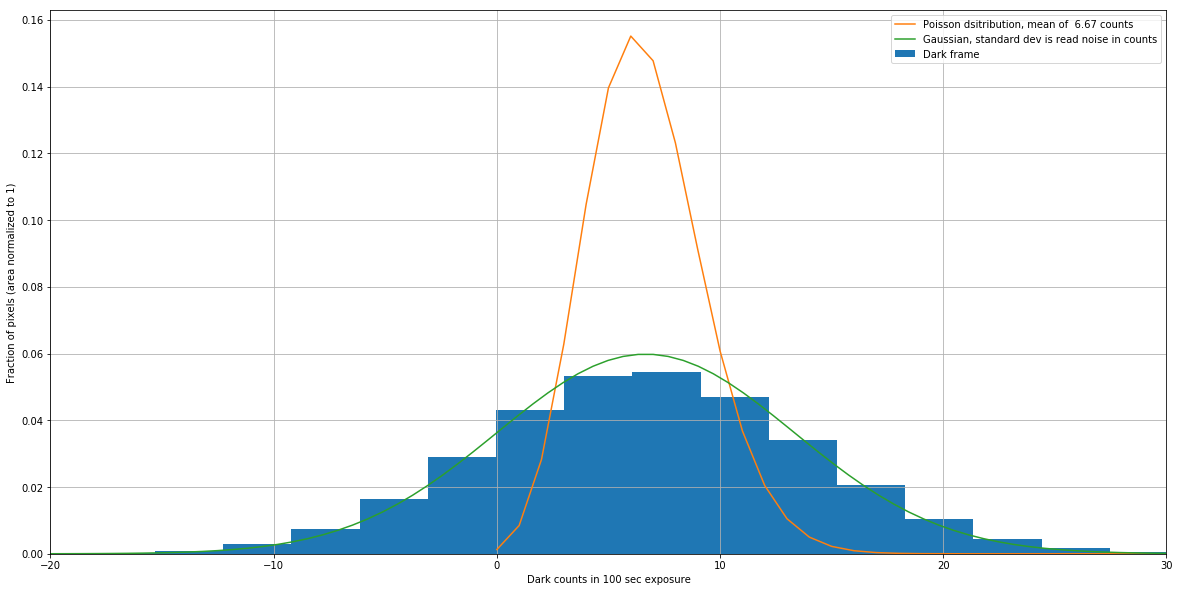

In [9]:
plt.figure(figsize=(20, 10))

plot_dark_with_distributions(darks[-1], high_read_noise, dark_rate, 
                             n_images=1, exposure=exposure, gain=gain)

plt.xlim(-20, 30);

**This dark frame measures noise, not dark current**

The pixel distribution is clearly a Gaussian distribution with a width determined by the read noise, not the underlying Poisson distribution that a dark frame is trying to measure. The only way around this (assuming the dark current is large enough that it needs to be subtracted at all) is to make the exposure long enough that the expected counts exceed the dark current.

We explore that case below by adding in a much smaller amount of noise.

**Combining does not recover the dark current**

The plots below show the result of averaging several (20 in this case) dark frames together. One might hope that averaging reduces the noise enough that the distribution of pixels becomes the Poisson distribution expected for a dark frame. It does not.

*Note:* To correctly calculate the expected distribution of counts in the average of the dark frames one should start with the expectations for the *sum* of the images, them scale counts down by the number of images and the distribution up by the same factor so that the distribution remains normalized.

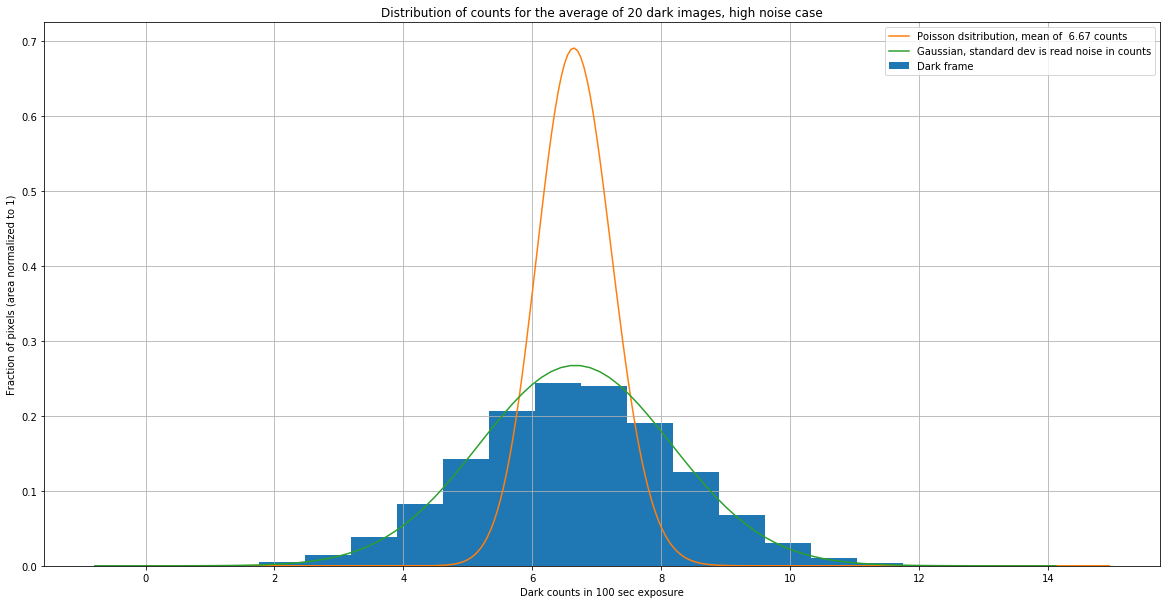

In [10]:
plt.figure(figsize=(20, 10))

plot_dark_with_distributions(image_average, high_read_noise, dark_rate, 
                             n_images=20, exposure=exposure, gain=gain)

plt.title("Distribution of counts for the average of 20 dark images, high noise case");

Even the combination of 20 dark frames doesn't lead to a Poisson distribution; the distribution is still a Gaussian whose width is determined by the read noise and the number of images.

### Low noise 

In this case the read noise is 1 $e^-$, lower by a factor of ten than the expected dark current for this exposure time, 10$e^-$.

This case almost never occurs in real CCDs but it illustrates that with a low enough read noise one can recover the Poisson distribution of the dark current.

In [11]:
low_read_noise = 1

darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=low_read_noise, 
                             gain=gain, exposure=exposure, image_size=image_size)

image_average = darks.mean(axis=0)

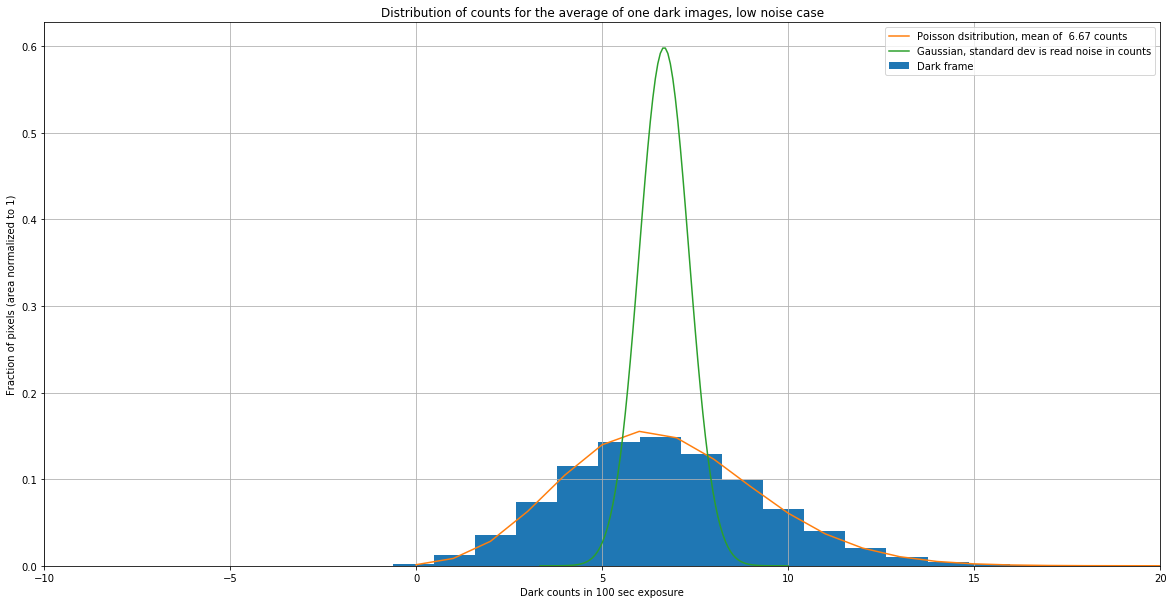

In [12]:
plt.figure(figsize=(20, 10))


plot_dark_with_distributions(darks[-1], low_read_noise, dark_rate, 
                             n_images=1, exposure=exposure, gain=gain)

#plt.ylim(0, 0.8)
plt.xlim(-10, 20)
plt.title("Distribution of counts for the average of one dark images, low noise case");

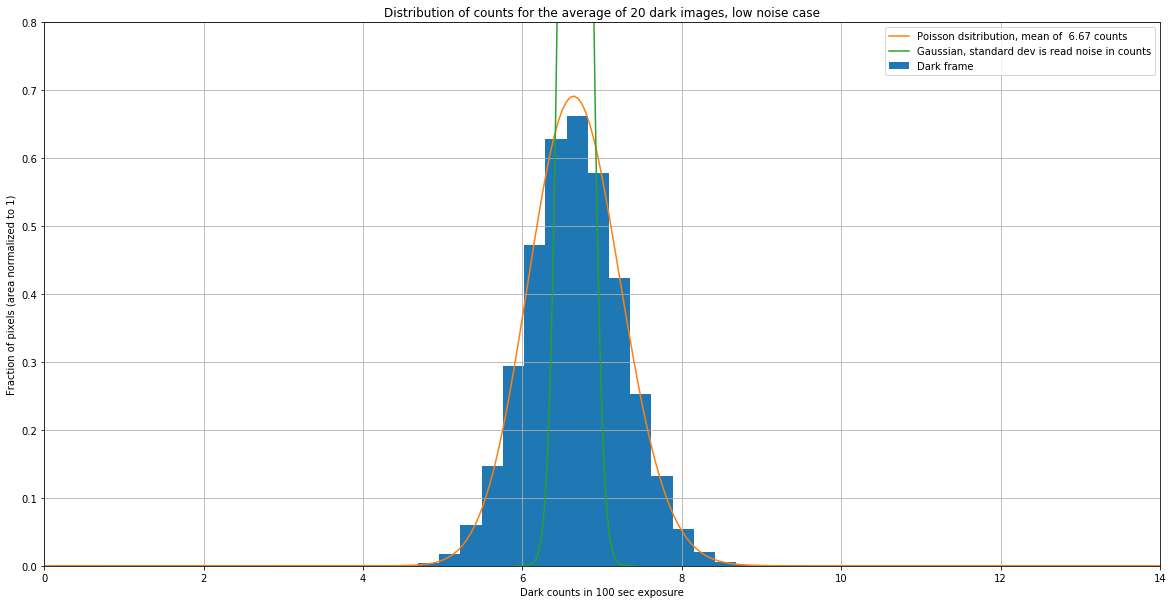

In [13]:
plt.figure(figsize=(20, 10))


plot_dark_with_distributions(image_average, low_read_noise, dark_rate, 
                             n_images=20, exposure=exposure, gain=gain)

plt.ylim(0, 0.8)
plt.xlim(0, 14)
plt.title("Distribution of counts for the average of 20 dark images, low noise case");

**Dark frame is measuring dark current**

Unlike the high noise case, the pixels in a single low-noise dark frame follow the Poisson distribution expected for the dark current in this simulated camera. When multiple images are combined the pixels still follow the Poisson distribution, as expected in this case.